INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [12]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [13]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

### Détection des objets (Mask R-CNN)

In [14]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [15]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [16]:
def calc_cost_matrix(tracked_objects, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(tracked_objects[i].histogram, hist_current)
    return cost_matrix


def mean_shift(tracked_obj, current_img):           
    retro = cv2.calcBackProject([current_img], [0], tracked_obj.histogram, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, current_img, current_bboxes):    
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on coordinates
        if tracked_objects[row_ind[i]].is_close_from(current_bboxes[col_ind[i]]):
            # model detected object, update it with its predicted bbox
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
    
    # apply mean-shift to tracked objects that were not detected by the model
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, current_img)
            ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False
            
            
    return row_ind, col_ind

### Algorithme principal

In [17]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.count = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
        self.histogram = None
    
    
    def update(self, x_min, y_min, x_max, y_max, count = None):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        if count is not None:
            self.count = count
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def is_close_from(self, box):
        limit = 100
        if box[0] < self.x_min - limit or box[0] > self.x_max + limit:
            return False
        elif box[2] < self.x_min - limit or box[2] > self.x_max + limit:
            return False
        elif box[1] < self.y_min - limit or box[1] > self.y_max + limit:
            return False
        elif box[3] < self.y_min - limit or box[3] > self.y_max + limit:
            return False
        else:
            return True
        
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [26]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    for ob in tracked_objects.values():
        ob.histogram = calc_color_hist(prev_img, ob.box())
    
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [19]:
def algo_mot():
    return None

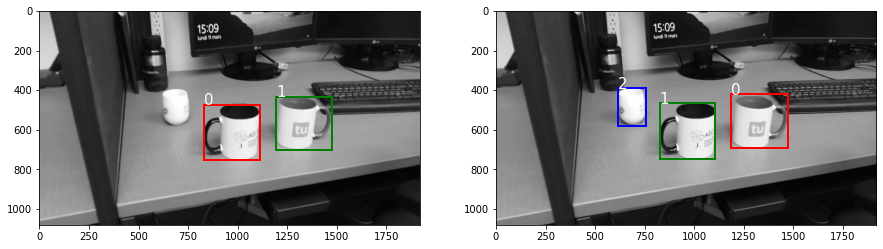

1 830 1112 474 755
2 1194 1479 433 700
[0 1]
[1 0]
1 826 1105 466 746
2 1185 1472 421 694


In [25]:
### Test association des données ###
img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)

img2 = cv2.imread(os.path.join(source_path, "frame2.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

axarr[1].imshow(img2, cmap = plt.cm.gray)
for i, b in enumerate(b2):
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img2, b2)
print(row_ind)
print(col_ind)

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [ ]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}


algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg
Progress: frame46.jpg
Progress: frame51.jpg


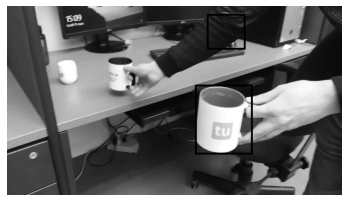

frame151.jpg
151 1 1150 1362 50 244

151 2 1082 1403 454 843



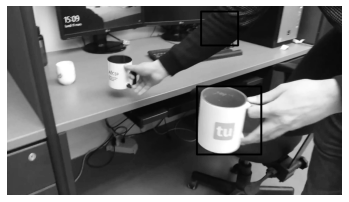

frame152.jpg
152 1 1112 1324 31 225

152 2 1088 1457 459 848



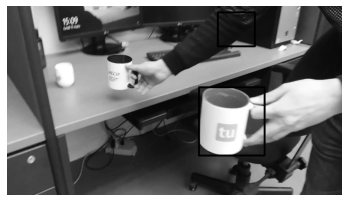

frame153.jpg
153 1 1208 1420 36 230

153 2 1100 1476 464 854



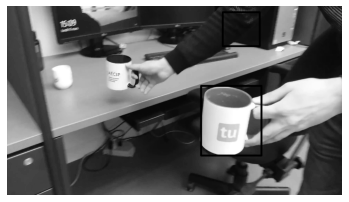

frame154.jpg
154 1 1236 1448 35 229

154 2 1112 1458 456 854



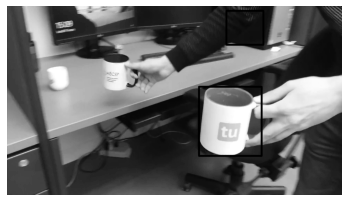

frame155.jpg
155 1 1257 1469 27 221

155 2 1100 1459 461 856



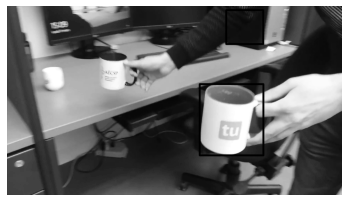

frame156.jpg
156 1 1256 1468 23 217

156 2 1104 1469 446 853



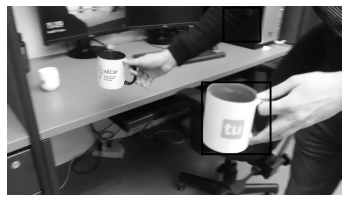

frame157.jpg
157 1 1240 1452 9 203

157 2 1117 1510 436 846



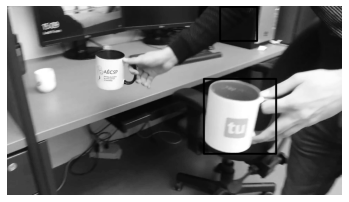

frame158.jpg
158 1 1221 1433 5 199

158 2 1128 1542 416 844



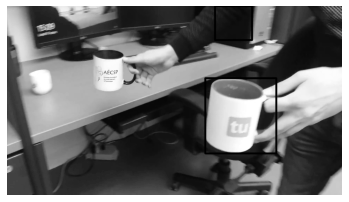

frame159.jpg
159 1 1192 1404 0 194

159 2 1136 1543 412 842



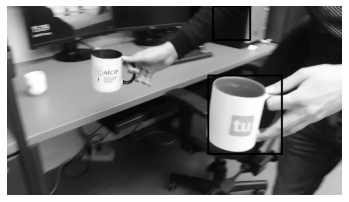

frame160.jpg
160 1 1181 1393 0 194

160 2 1153 1575 397 845



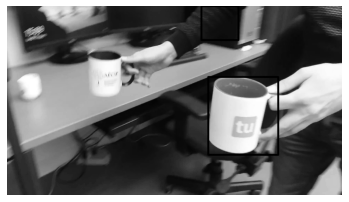

frame161.jpg
161 1 1114 1326 0 194

161 2 1153 1554 405 850



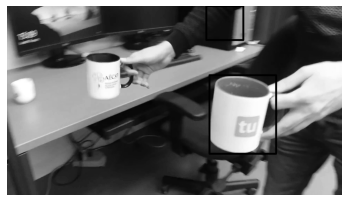

frame162.jpg
162 1 1142 1354 0 194

162 2 1160 1542 395 844



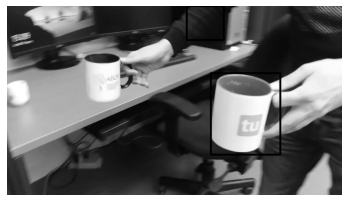

frame163.jpg
163 1 1030 1242 0 194

163 2 1168 1566 383 849



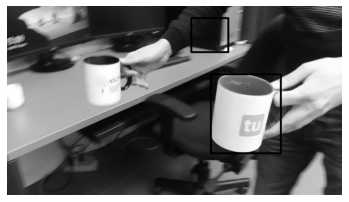

frame164.jpg
164 1 1056 1268 69 263

164 2 1168 1569 390 841



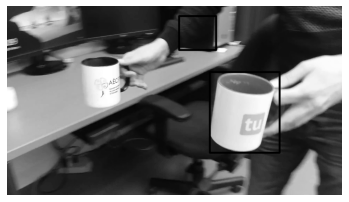

frame165.jpg
165 1 986 1198 57 251

165 2 1162 1562 377 838



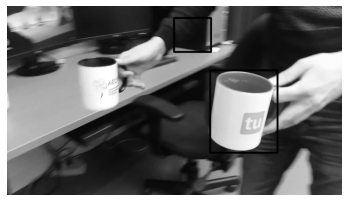

frame166.jpg
166 1 957 1169 68 262

166 2 1164 1550 367 838



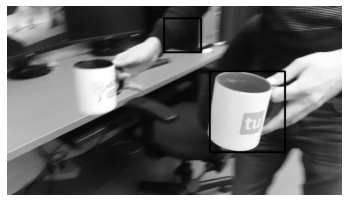

frame167.jpg
167 1 900 1112 70 264

167 2 1162 1593 373 835



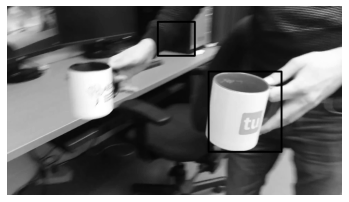

frame168.jpg
168 1 864 1076 90 284

168 2 1155 1573 374 833



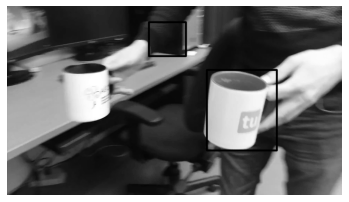

frame169.jpg
169 1 813 1025 92 286

169 2 1145 1546 365 825



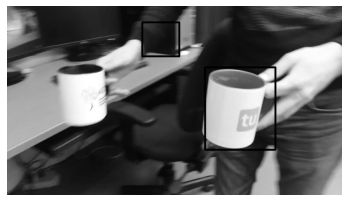

frame170.jpg
170 1 775 987 93 287

170 2 1135 1538 350 821



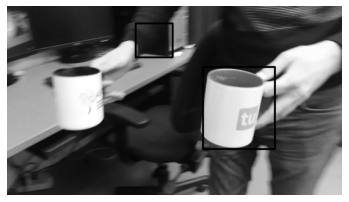

frame171.jpg
171 1 737 949 99 293

171 2 1123 1535 348 817



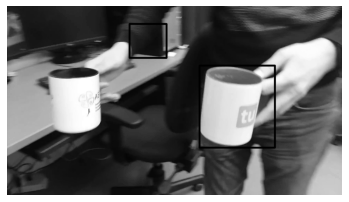

frame172.jpg
172 1 702 914 102 296

172 2 1103 1535 340 809



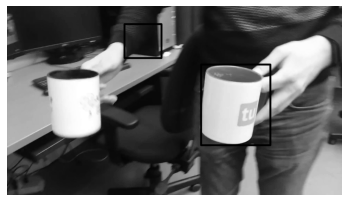

frame173.jpg
173 1 673 885 103 297

173 2 1112 1509 334 795



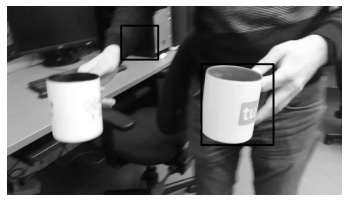

frame174.jpg
174 1 654 866 112 306

174 2 1114 1527 332 794



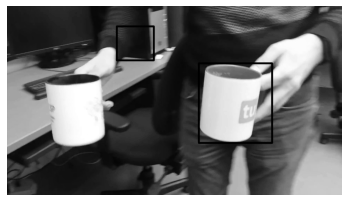

frame175.jpg
175 1 629 841 116 310

175 2 1099 1519 327 782



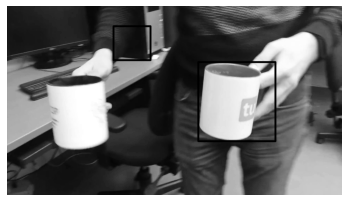

frame176.jpg
176 1 610 822 115 309

176 2 1096 1538 320 772



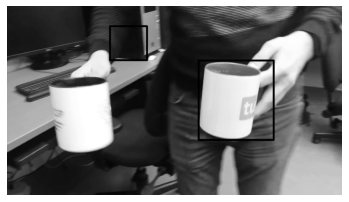

frame177.jpg
177 1 590 802 115 309

177 2 1098 1528 311 765



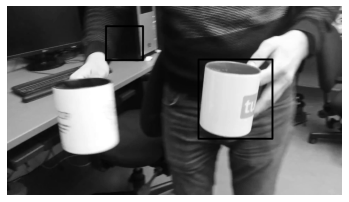

frame178.jpg
178 1 567 779 115 309

178 2 1097 1521 305 758



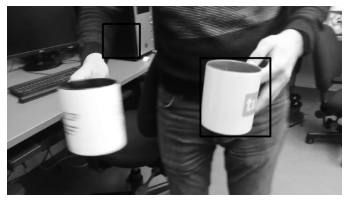

frame179.jpg
179 1 549 761 102 296

179 2 1108 1509 297 745



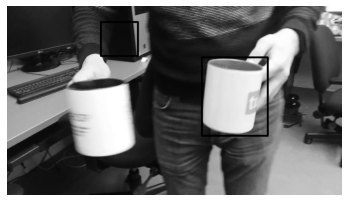

frame180.jpg
180 1 538 750 91 285

180 2 1117 1494 293 741



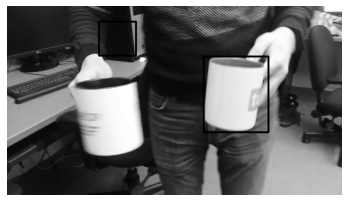

frame181.jpg
181 1 527 739 89 283

181 2 1127 1498 288 721



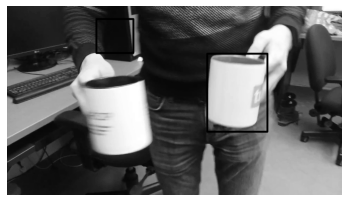

frame182.jpg
182 1 512 724 74 268

182 2 1147 1492 272 718



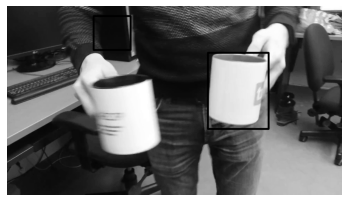

frame183.jpg
183 1 496 708 57 251

183 2 1151 1499 267 702



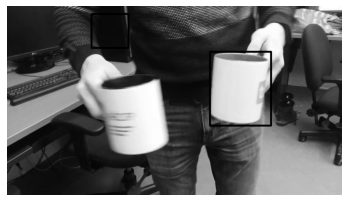

frame184.jpg
184 1 484 696 45 239

184 2 1163 1513 261 683



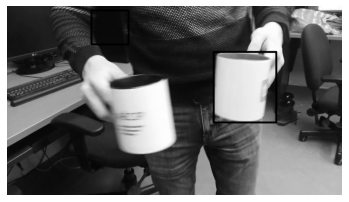

frame185.jpg
185 1 484 696 25 219

185 2 1184 1543 262 665



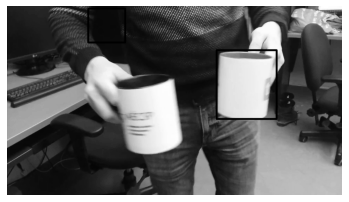

frame186.jpg
186 1 465 677 14 208

186 2 1201 1545 252 645



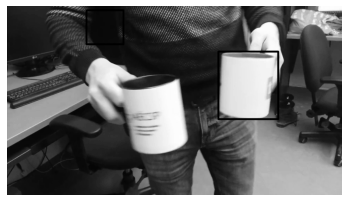

frame187.jpg
187 1 455 667 24 218

187 2 1211 1554 260 646



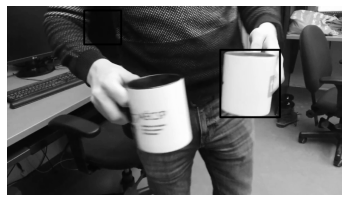

frame188.jpg
188 1 442 654 25 219

188 2 1222 1564 250 635



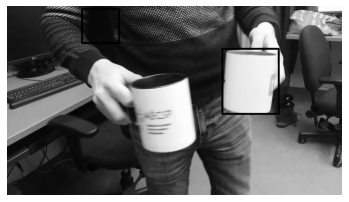

frame189.jpg
189 1 430 642 17 211

189 2 1234 1557 244 616



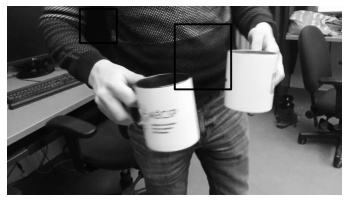

frame190.jpg
190 1 417 629 17 211

190 2 961 1284 104 476



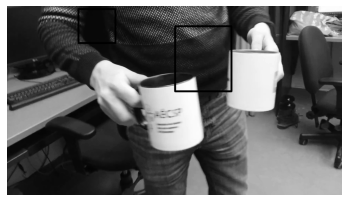

frame191.jpg
191 1 409 621 17 211

191 2 963 1286 115 487



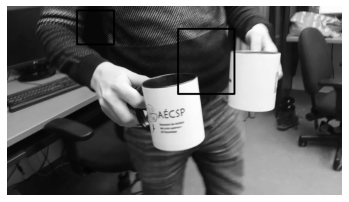

frame192.jpg
192 1 401 613 25 219

192 2 980 1303 130 502



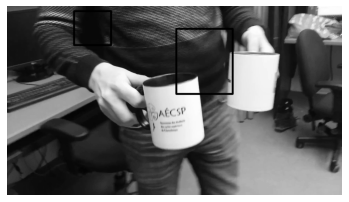

frame193.jpg
193 1 384 596 29 223

193 2 970 1293 130 502



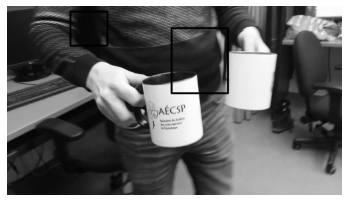

frame194.jpg
194 1 363 575 32 226

194 2 943 1266 126 498



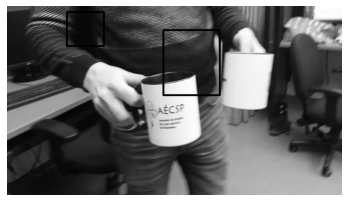

frame195.jpg
195 1 343 555 34 228

195 2 896 1219 137 509



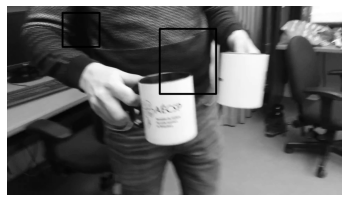

frame196.jpg
196 1 318 530 39 233

196 2 875 1198 130 502



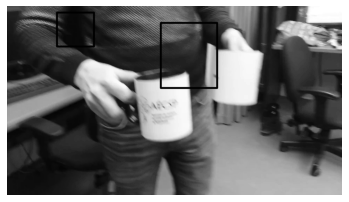

frame197.jpg
197 1 286 498 37 231

197 2 881 1204 96 468



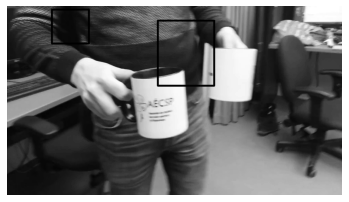

frame198.jpg
198 1 257 469 20 214

198 2 864 1187 83 455



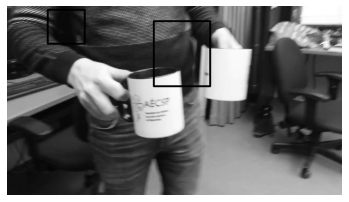

frame199.jpg
199 1 233 445 21 215

199 2 841 1164 86 458



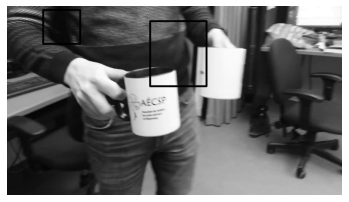

frame200.jpg
200 1 207 419 22 216

200 2 820 1143 86 458



In [57]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 151
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
